In [127]:
import geopandas as gpd
import pandas as pd
from sentinelsat import SentinelAPI
import json
from datetime import date
from cartopy import crs, feature
ccrs = crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import shapely.geometry
from numpy.random import randint
import numpy as np
import rasterio 
from imgproc import downloader, processor
import glob
from skimage import img_as_ubyte, exposure

from rasterio import mask
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%config InlineBackend.figure_format = 'retina'

authinfo = json.loads(open("../passwords.json", 'r').read())

WA_extent = [-125.3759765625,-116.3562011719,49.4716937852,45.2632885315]

In [3]:
lakesdata = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDWaterbody.shp"
fcodes = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDFCode.dbf"
IMAGE_DOWNLOAD_DIR = '/Volumes/wrangell-st-elias/research/sentinel-2'

nhd_waterbody = gpd.read_file(lakesdata)
fcodes = gpd.read_file(fcodes)
nhd_waterbody_coded = pd.merge(nhd_waterbody,
                               fcodes.drop('geometry', axis=1), 
                               left_on='FCODE', right_on='FCODE',
                               how='left')

In [4]:
biglakes = nhd_waterbody_coded[(nhd_waterbody_coded.HYDROGRAPH == 'Perennial') & (nhd_waterbody_coded.AREASQKM > 10) & (nhd_waterbody_coded.AREASQKM < 20)]
whichlake = np.where(biglakes.index == biglakes[biglakes.GNIS_NAME == 'Lake Whatcom'].index[0])[0][0]#randint(0, len(biglakes))


In [5]:
params = {
          'date' :  ('20161119', '20161225'), 
          'platformname' : 'Sentinel-2'
         }
products = downloader.searchOverlapping(biglakes.iloc[whichlake].geometry.envelope, params)
products

,uuid,filename,instrumentshortname,endposition,identifier,instrumentname,relativeorbitnumber,producttype,sensoroperationalmode,orbitnumber,...,title,platformname,summary,link_icon,processingbaseline,s2datatakeid,platformidentifier,format,processed,geometry
1f28d037-1661-43f4-9738-889a92666828,1f28d037-1661-43f4-9738-889a92666828,S2A_OPER_PRD_MSIL1C_PDMC_20161125T015915_R013_...,MSI,2016-11-24 19:07:22.000,S2A_OPER_PRD_MSIL1C_PDMC_20161125T015915_R013_...,Multi-Spectral Instrument,13,S2MSI1C,INS-NOBS,7446,...,S2A_OPER_PRD_MSIL1C_PDMC_20161125T015915_R013_...,Sentinel-2,"Date: 2016-11-24T19:07:22Z, Instrument: MSI, M...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161124T190722_007446_N02.04,2015-000A,SAFE,F,POLYGON ((-122.5088155930985 48.66185179890427...
1f2b10ea-c6fa-4551-9f67-1d7bf6ab39d2,1f2b10ea-c6fa-4551-9f67-1d7bf6ab39d2,S2A_OPER_PRD_MSIL1C_PDMC_20161130T001531_R056_...,MSI,2016-11-27 19:17:32.000,S2A_OPER_PRD_MSIL1C_PDMC_20161130T001531_R056_...,Multi-Spectral Instrument,56,S2MSI1C,INS-NOBS,7489,...,S2A_OPER_PRD_MSIL1C_PDMC_20161130T001531_R056_...,Sentinel-2,"Date: 2016-11-27T19:17:32Z, Instrument: MSI, M...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161127T191732_007489_N02.04,2015-000A,SAFE,F,"POLYGON ((-123.0002720958938 48.7530130044756,..."
41e68fb7-0de9-4b9e-8b1d-559b1593cba9,41e68fb7-0de9-4b9e-8b1d-559b1593cba9,S2A_MSIL1C_20161214T190802_N0204_R013_T10UEV_2...,MSI,2016-12-14 19:08:02.026,S2A_MSIL1C_20161214T190802_N0204_R013_T10UEV_2...,Multi-Spectral Instrument,13,S2MSI1C,INS-NOBS,7732,...,S2A_MSIL1C_20161214T190802_N0204_R013_T10UEV_2...,Sentinel-2,"Date: 2016-12-14T19:08:02.026Z, Instrument: MS...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161214T190802_007732_N02.04,2015-000A,SAFE,NaN,"POLYGON ((-122.508690836681 48.66185099175762,..."
43cdc654-9c86-4c40-8914-a89ba80bbbe3,43cdc654-9c86-4c40-8914-a89ba80bbbe3,S2A_OPER_PRD_MSIL1C_PDMC_20161129T211821_R056_...,MSI,2016-11-27 19:17:32.000,S2A_OPER_PRD_MSIL1C_PDMC_20161129T211821_R056_...,Multi-Spectral Instrument,56,S2MSI1C,INS-NOBS,7489,...,S2A_OPER_PRD_MSIL1C_PDMC_20161129T211821_R056_...,Sentinel-2,"Date: 2016-11-27T19:17:32Z, Instrument: MSI, M...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161127T191732_007489_N02.04,2015-000A,SAFE,F,POLYGON ((-123.0002770774474 49.65272281450567...
655a3d8c-dfa0-4fff-bb42-0ff8946998e7,655a3d8c-dfa0-4fff-bb42-0ff8946998e7,S2A_MSIL1C_20161217T191812_N0204_R056_T10UEV_2...,MSI,2016-12-17 19:18:12.026,S2A_MSIL1C_20161217T191812_N0204_R056_T10UEV_2...,Multi-Spectral Instrument,56,S2MSI1C,INS-NOBS,7775,...,S2A_MSIL1C_20161217T191812_N0204_R056_T10UEV_2...,Sentinel-2,"Date: 2016-12-17T19:18:12.026Z, Instrument: MS...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161217T191812_007775_N02.04,2015-000A,SAFE,NaN,POLYGON ((-123.0002770774474 49.65272281450567...
8e7f2e89-f4bd-42ce-bbd4-aa69f062f55f,8e7f2e89-f4bd-42ce-bbd4-aa69f062f55f,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEU_2...,MSI,2016-12-24 19:08:12.026,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEU_2...,Multi-Spectral Instrument,13,S2MSI1C,INS-NOBS,7875,...,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEU_2...,Sentinel-2,"Date: 2016-12-24T19:08:12.026Z, Instrument: MS...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161224T190812_007875_N02.04,2015-000A,SAFE,NaN,POLYGON ((-122.8246529848711 47.76404604469253...
93b051ba-504c-4746-8f74-c422187d33aa,93b051ba-504c-4746-8f74-c422187d33aa,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_2...,MSI,2016-12-24 19:08:12.026,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_2...,Multi-Spectral Instrument,13,S2MSI1C,INS-NOBS,7875,...,S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_2...,Sentinel-2,"Date: 2016-12-24T19:08:12.026Z, Instrument: MS...",https://scihub.copernicus.eu/dhus/odata/v1/Pro...,02.04,GS2A_20161224T190812_007875_N02.04,2015-000A,SAFE,NaN,POLYGON ((-122.4897108011823 48.66172819509295...
b3be9a38-60ee-4237-81f3-f893b2f233c

In [6]:
def plotGeomOnTiles(tiles, geom):
    bounds = tiles.total_bounds
    ax = plt.axes(projection=crs.Mercator().GOOGLE)
    ax.set_extent([bounds[2]+0.5, bounds[0]-0.5, bounds[1]-0.5, bounds[3]+0.5])
    states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none', name='admin_1_states_provinces_shp')
    ax.add_feature(states)


    #ax.add_geometries(products.geometry, crs=crs.PlateCarree(), facecolor=, alpha=0.2, label='sentinel')
    for i, shape in tiles.iterrows():
        middle = shape.geometry.centroid
        ax.text(middle.x, middle.y, shape['ingestiondate'].day, transform=crs.PlateCarree())
        ax.add_geometries([shape.geometry], facecolor='green', crs=crs.PlateCarree(), alpha=0.2)
    ax.add_geometries([geom.buffer(0)], crs=crs.PlateCarree(), facecolor='blue', label='lake')
    ax.legend()


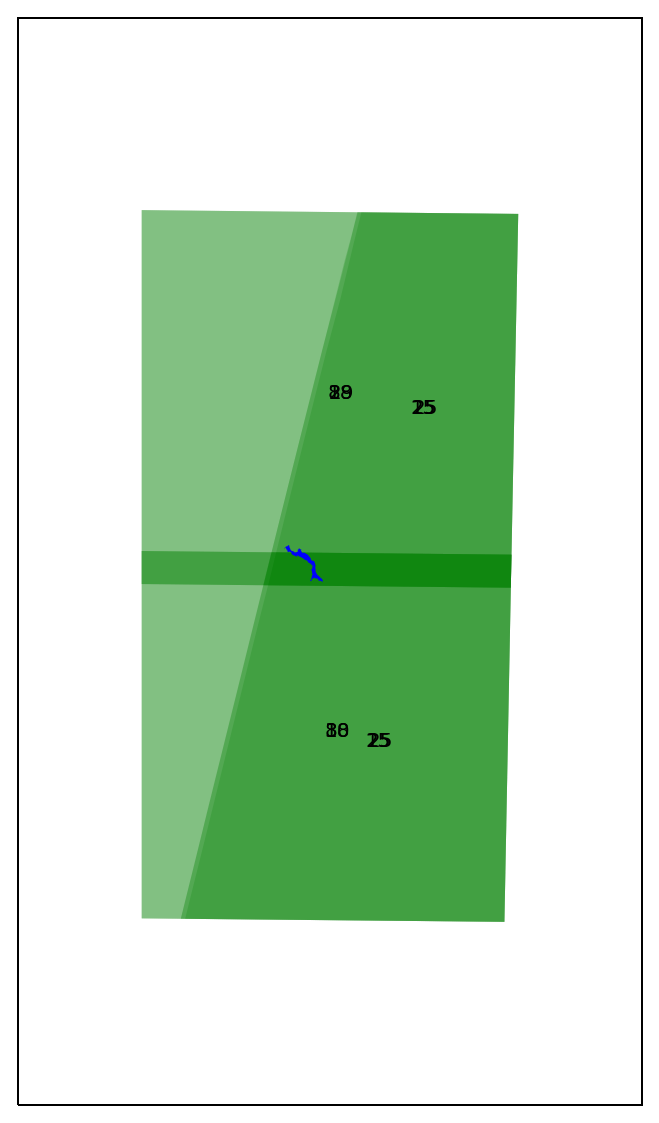

In [7]:
plotGeomOnTiles(products, biglakes.iloc[whichlake].geometry)

In [8]:
m = folium.Map([43, -120], zoom_start=6, control_scale=True)
for i, product in products.iterrows():
    c = folium.GeoJson(shapely.geometry.mapping(product.geometry), 
                       style_function = lambda feature: {'fillColor': '#ffaf00','color': 'blue', 'weight': 1.5,'dashArray': '5, 5'})#,highlight_function = lambda feature: {'fillColor': '#ffaf00','color': 'green', 'weight': 3,'dashArray': '5, 5'}
    print(product['ingestiondate'])
    c.add_child(folium.Popup(str(product['ingestiondate'])))
    c.add_to(m)

folium.GeoJson(shapely.geometry.mapping(biglakes.iloc[whichlake].geometry)).add_to(m)
m

2016-11-25 02:31:37.983000
2016-11-30 04:03:39.703000
2016-12-15 09:49:45.452000
2016-11-29 22:46:24.590000
2016-12-18 00:46:23.296000
2016-12-25 19:17:13.404000
2016-12-25 19:16:43.475000
2016-12-08 13:38:47.371000
2016-12-15 09:50:03.246000
2016-12-08 13:38:47.041000
2016-12-18 00:46:23.560000
2016-11-25 02:29:38.235000


---


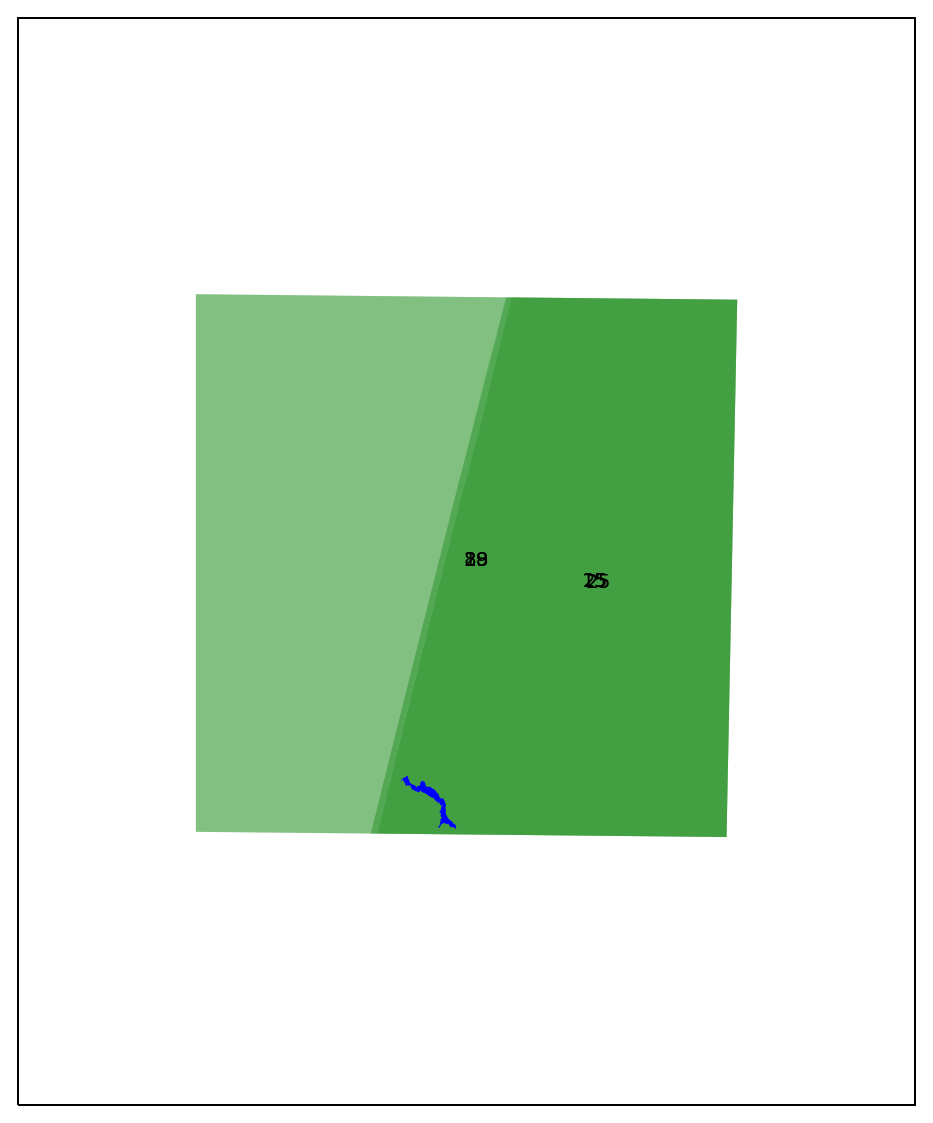

In [9]:
containslake = products[products.contains(biglakes.iloc[whichlake].geometry)]
plotGeomOnTiles(containslake, biglakes.iloc[whichlake].geometry)

In [10]:
most_recent = containslake[containslake.ingestiondate == containslake.ingestiondate.max()]


In [24]:
imgpath = downloader.downloadProduct(most_recent.index, IMAGE_DOWNLOAD_DIR)
print(imgpath)

/Volumes/wrangell-st-elias/research/sentinel-2/S2A_MSIL1C_20161224T190812_N0204_R013_T10UEV_20161224T190807.SAFE/


In [25]:
b4 = rasterio.open(glob.glob("%sGRANULE/*/IMG_DATA/*B%02d.jp2" % (imgpath, 4))[0])
b3 = rasterio.open(glob.glob("%sGRANULE/*/IMG_DATA/*B%02d.jp2" % (imgpath, 3))[0])
b2 = rasterio.open(glob.glob("%sGRANULE/*/IMG_DATA/*B%02d.jp2" % (imgpath, 2))[0])

In [26]:
stack = processor._stackBands([b4, b3, b2])

In [27]:
stack = img_as_ubyte(stack)
p2, p98 = np.percentile(stack, (2, 98))
stack = exposure.rescale_intensity(stack, in_range=(p2, p98))

/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


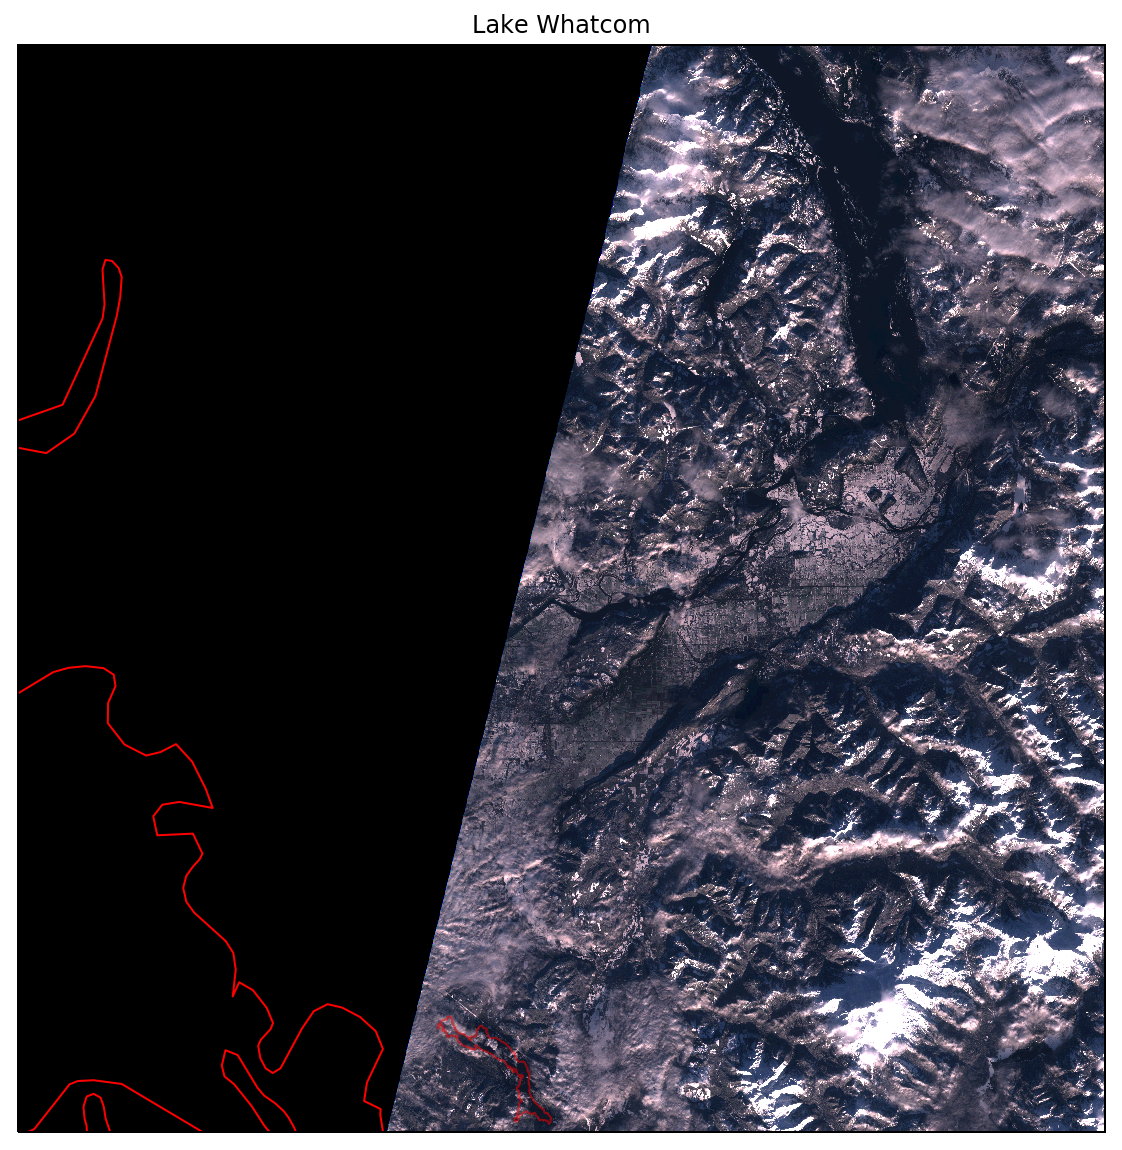

In [28]:
src = b4
xmin = src.transform[0]
xmax = src.transform[0] + src.transform[1]*src.width
ymin = src.transform[3] + src.transform[5]*src.height
ymax = src.transform[3]

crs = ccrs.epsg(src.crs['init'].split(':')[1])

ax = plt.axes(projection=crs)
plt.title(biglakes.iloc[whichlake].GNIS_NAME)
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
plt.imshow(np.squeeze(stack), origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
ax.coastlines(resolution='10m', color='red', linewidth=1)
ax.add_geometries([biglakes.iloc[whichlake].geometry.buffer(0)], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', label='lake', alpha=0.5, )
plt.savefig('test.png')

---


In [118]:
import uuid
tmpdir = '/Volumes/wrangell-st-elias/tmp/'
def _rand_filename(ftype, root = '.'):
    if root[-1] == '/' : root = root[:-1]
    return "%s/%s.%s" % (root, uuid.uuid4(), ftype)

In [148]:
import imp
imp.reload(processor)
for b_idx, band in enumerate([b4, b3, b2]):
    fname = _rand_filename("B%02d.tif" % b_idx, tmpdir) 
    print(fname)
    processor.extractGeomToFile(biglakes.iloc[whichlake].geometry, band, '4326', fname)


/Volumes/wrangell-st-elias/tmp/65b582a6-e408-4363-b9f7-ba573e5ad430.B00.tif
/Volumes/wrangell-st-elias/tmp/67db7872-ccf0-418e-9b6f-88bf37981fa8.B01.tif
/Volumes/wrangell-st-elias/tmp/35e4ce74-1a49-4a39-8607-92e64a623490.B02.tif


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


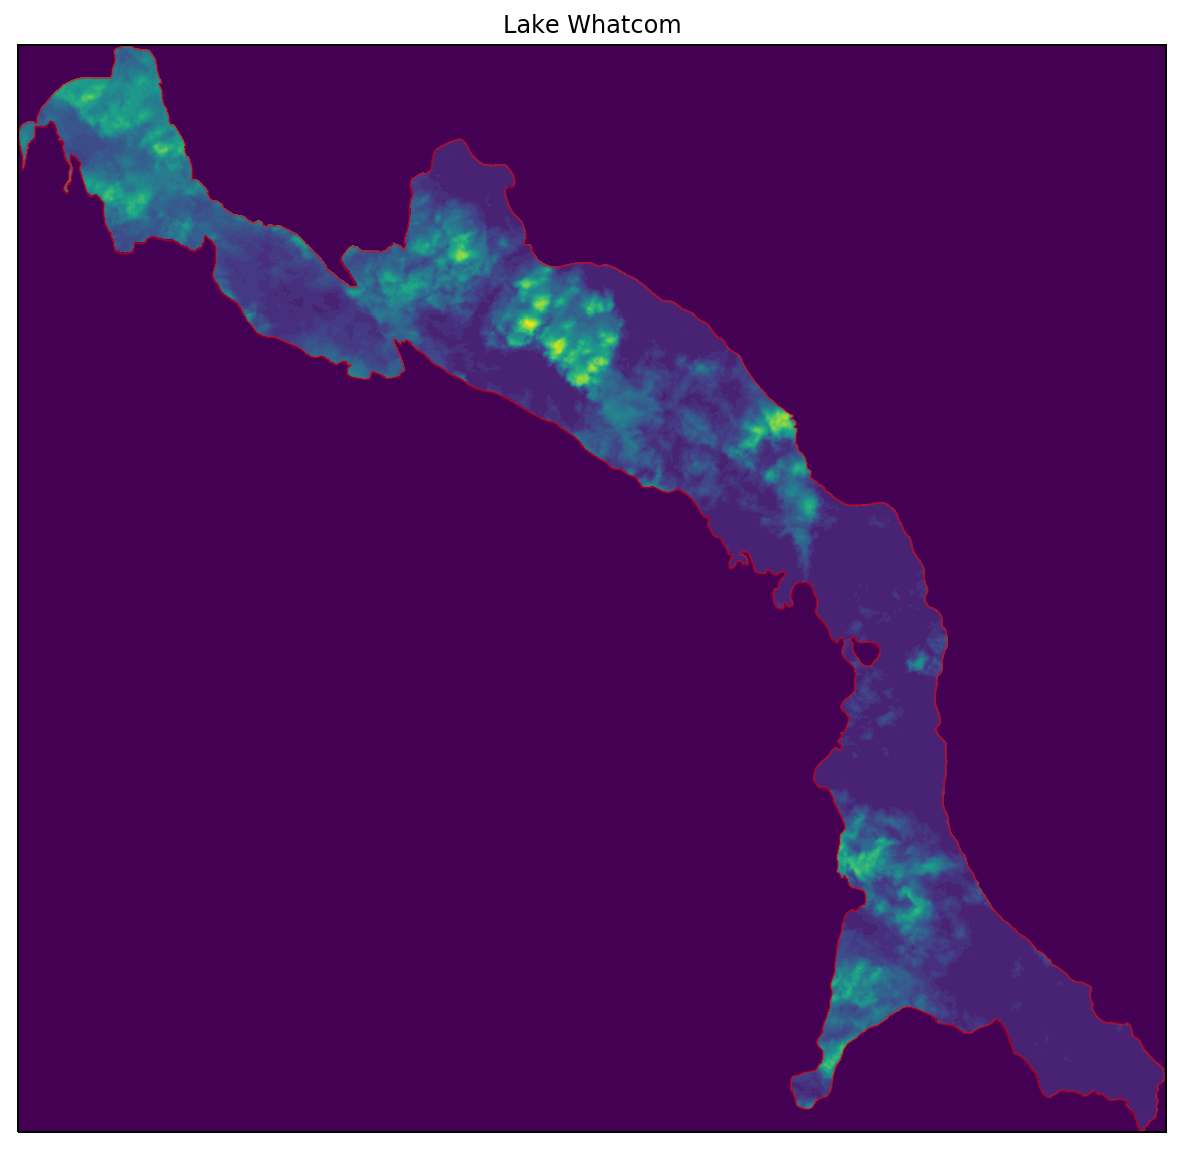

In [156]:
crop1 = rasterio.open('/Volumes/wrangell-st-elias/tmp/67db7872-ccf0-418e-9b6f-88bf37981fa8.B01.tif', 'r')
crop1_im = crop1.read()
crop1_im = img_as_ubyte(crop1_im)
src = crop1
xmin = src.transform[0]
xmax = src.transform[0] + src.transform[1]*src.width
ymin = src.transform[3] + src.transform[5]*src.height
ymax = src.transform[3]
crs = ccrs.epsg(src.crs['init'].split(':')[1])
ax = plt.axes(projection=crs)
plt.title(biglakes.iloc[whichlake].GNIS_NAME)
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
plt.imshow(np.squeeze(crop1_im), origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
ax.coastlines(resolution='10m', color='red', linewidth=1)
ax.add_geometries([biglakes.iloc[whichlake].geometry.buffer(0)], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', label='lake', alpha=0.5, )
plt.savefig('test.png')